In [41]:
import pandas as pd
import sys
import os

data_ingestion_path = os.path.abspath(os.path.join('..', 'Data_Ingestion')) 
sys.path.append(data_ingestion_path)

from model import ModelPipeline

In [42]:
df = pd.read_csv("../Data/Cleaned/cleaned.csv")
i = df.sample(150)

In [43]:
model = ModelPipeline()
model

Device set to use cpu
/home/colonel/Desktop/FASA/Env/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.

Device set to use cpu
Device set to use cpu
Device set to use cpu


In [61]:
model.build("My trip ended up triple amount")

{'overall_sentiment': 'neutral',
 'overall_emotion': 'disappointment',
 'aspect_analysis': {'price': 'negative'},
 'churn_risk': 'low'}

In [46]:
df_pred = i['text'].apply(model.build).apply(pd.Series)

In [47]:
final = pd.concat([i,df_pred],axis=1)

In [59]:
#final.to_csv("../Data/Cleaned/predicted.csv")

In [60]:
final = pd.read_csv("../Data/Cleaned/predicted.csv")

In [48]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import textwrap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import ast

#### Overall Sentiment

In [49]:
fig1 = px.pie(final, names='overall_sentiment', title='<b>Overall Sentiment Distribution</b>',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig1.update_traces(textposition='inside', textinfo='percent+label')
fig1.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig1.show()

#### Sentiment Trend

In [50]:
final1 = final.copy()
final1['date'] = pd.to_datetime(final1['date'])

final1['year'] = final1['date'].dt.year


yearly_counts = final1.groupby(['year', 'overall_sentiment']).size().unstack(fill_value=0)

df_melted = yearly_counts.reset_index().melt(id_vars='year', var_name='Sentiment', value_name='Count')


fig = px.line(df_melted, x='year', y='Count', color='Sentiment', markers=True, title='Sentiment Trend per Year')
fig.show()


#### Source Sentiment

In [51]:
fig4 = px.histogram(final, y='source', color='overall_sentiment',
                   title='<b>Source Sentiment</b>',
                   barmode='stack',
                   color_discrete_map={
                       'positive': '#27ae60',
                       'negative': '#c0392b',
                       'neutral': '#bdc3c7'
                   })
fig4.update_layout(xaxis_title='Count', yaxis_title='Source')

#### Churn Risk

In [52]:
churn_by_company = pd.crosstab(final['company'], final['churn_risk'], normalize='index') * 100
churn_by_company = churn_by_company.reset_index()

fig = px.bar(churn_by_company, 
             x='company', 
             y='high',
             color='high',
             color_continuous_scale=['#2ecc71', '#f39c12', '#e74c3c'],
             range_color=[0, 100],
             title='<b>Percentage of High Churn Risk Reviews by Company</b>',
             labels={'high': 'High Churn Risk (%)'},
             text='high',
             height=600)

avg_churn = churn_by_company['high'].mean()
fig.add_hline(y=avg_churn, line_dash="dot", 
              annotation_text=f"Industry Avg: {avg_churn:.1f}%", 
              annotation_position="top left")

fig.update_layout(
    xaxis_title="Company",
    yaxis_title="Percentage of High Churn Risk Reviews",
    coloraxis_showscale=False,
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.show()

#### Response Rate

In [53]:
response_analysis = final.groupby(['company', final['response']]).size().unstack(fill_value=0)

if True not in response_analysis.columns:
    response_analysis[True] = 0 


response_analysis['response_rate'] = (response_analysis.get(True, 0) / 
                                    (response_analysis.get(True, 0) + response_analysis.get(False, 0))) * 100


fig = px.bar(response_analysis.reset_index(),
            x='company', y='response_rate',
            title='<b>Company Response Rates</b> (Sample Size: {})'.format(len(df)),
            color='company',
            text='response_rate')
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(yaxis_title='Response Rate (%)', 
                    xaxis_title='Company',
                    yaxis_range=[0, 100]) 
fig.show()


#### Aspect 

In [54]:
aspect_data = []
for _, row in final.iterrows():
    for aspect, sentiment in row['aspect_analysis'].items():
        aspect_data.append({'aspect': aspect, 'sentiment': sentiment})
aspect_df = pd.DataFrame(aspect_data)

fig4 = px.histogram(aspect_df, y='aspect', color='sentiment',
                   title='<b>Sentiment Distribution by Aspect</b>',
                   barmode='stack',
                   color_discrete_map={
                       'positive': '#27ae60',
                       'negative': '#c0392b',
                       'neutral': '#bdc3c7'
                   })
fig4.update_layout(xaxis_title='Aspect', yaxis_title='Count')

#### Emotion Frequency

In [55]:
emotion_counts = final['overall_emotion'].value_counts().reset_index()
fig2 = px.line_polar(emotion_counts, r='count', theta='overall_emotion', 
                    line_close=True, title='<b>Emotion Frequency Analysis</b>')
fig2.update_traces(fill='toself')
fig2.show()

#### Emotion Aspect Co-occurrence

In [56]:
records = []
for _, row in final.iterrows():
    emotion = row['overall_emotion']
    aspects = row['aspect_analysis']
    if isinstance(aspects, dict):  
        for aspect in aspects:
            records.append({'Emotion': emotion, 'Aspect': aspect})


df_expanded = pd.DataFrame(records)

heatmap_data = df_expanded.groupby(['Emotion', 'Aspect']).size().reset_index(name='Count')

fig = px.density_heatmap(
    heatmap_data,
    x='Aspect',
    y='Emotion',
    z='Count',
    color_continuous_scale='Purples',
    title='Emotion Aspect Co-occurrence',
    text_auto=True
)

fig.update_layout(
    xaxis_title="Aspect",
    yaxis_title="Emotion",
    height=600,
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()


#### Worldcloud

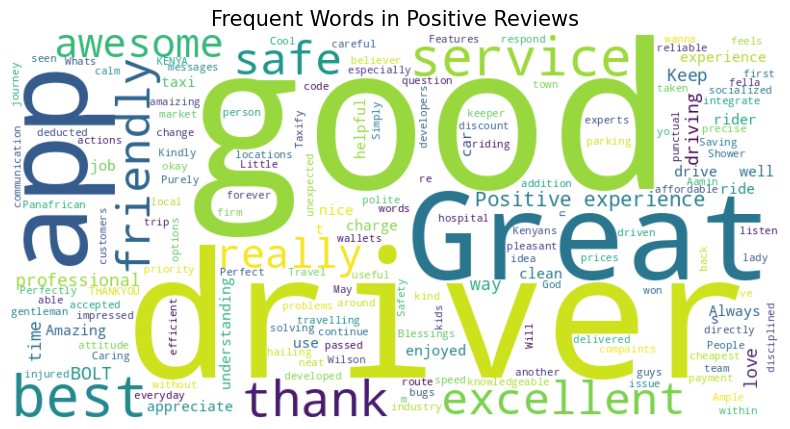

In [57]:
def generate_wordcloud(texts, title):
    plt.figure(figsize=(10, 5))
    wc = WordCloud(width=800, height=400, 
                  background_color='white',
                  colormap='viridis').generate(" ".join(texts))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis("off")
    plt.show()

pos_texts = final[final['overall_sentiment'] == 'positive']['text']
generate_wordcloud(pos_texts, "Frequent Words in Positive Reviews")


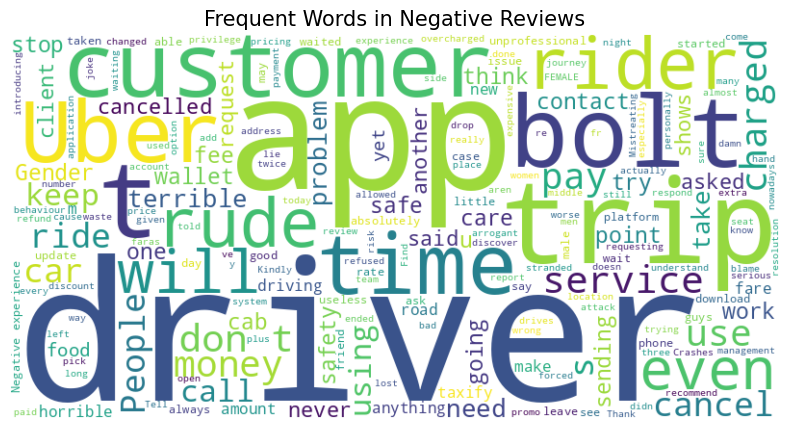

In [58]:
neg_texts = final[final['overall_sentiment'] == 'negative']['text']
generate_wordcloud(neg_texts, "Frequent Words in Negative Reviews")